In [3]:
USE_GPU = False
from typing import List, Tuple, Dict, Any, Optional
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import os
import glob
from typing import Dict
import re

In [52]:


def tensorboard_results_reward(log_matrix: Dict):
    log_df = {}
    for label, log_dir in log_matrix.items():
        print(f'Getting {label} results')
        events = EventAccumulator(log_dir)
        events.Reload()
        reward = events.Scalars('rollout/ep_rew_mean')
        df = pd.DataFrame({
                'wall_time': [x.wall_time for x in reward], # 'step': [x.step for x in loss],
                'step': [x.step for x in reward],
                'reward': [x.value for x in reward],
            })
        df['wall_time'] = pd.to_datetime(df['wall_time'], unit='s')
        log_df[label] = df
        
    return log_df


def tensorboard_results_loss(log_matrix: Dict):
    log_df = {}
    for label, log_dir in log_matrix.items():
        print(f'Getting {label} results')
        events = EventAccumulator(log_dir)
        events.Reload()
        reward = events.Scalars('train/loss')
        df = pd.DataFrame({
                'wall_time': [x.wall_time for x in reward], # 'step': [x.step for x in loss],
                'step': [x.step for x in reward],
                'loss': [x.value for x in reward],
            })
        df['wall_time'] = pd.to_datetime(df['wall_time'], unit='s')
        log_df[label] = df
        
    return log_df

        
def reward_window(reward_df):
    reward_df = reward_df.set_index('wall_time')
    reward_df = reward_df.resample('10T').mean()
    reward_df['step_indx'] = np.arange(1, reward_df.shape[0] + 1) 
    # reward_df['average session time'] = reward_df['reward']
    return reward_df

    return los
        
    


In [39]:
log_dirs_q1_dqn = {
    
    'DQN LABEL FCN': 's3://dissertation-data-dmiller/reinforcement_learning_incentives/n_files_30/mlp_label/results/2023-05-23-15-55/training_metrics/DQN_1',
    'DQN LABEL CNN': 's3://dissertation-data-dmiller/reinforcement_learning_incentives/n_files_30/cnn_label/results/2023-05-23-16-18/training_metrics/DQN_1',
    
    'DQN PRED FCN': 's3://dissertation-data-dmiller/reinforcement_learning_incentives/n_files_30/seq_40/results/2023-05-23-16-31/training_metrics/DQN_1',
    'DQN PRED CNN': 's3://dissertation-data-dmiller/reinforcement_learning_incentives/n_files_30/mlp_seq_40/results/2023-05-24-08-18/training_metrics/DQN_1',
    
    'DQN NONE FCN': 's3://dissertation-data-dmiller/reinforcement_learning_incentives/n_files_30/mlp_no_pred/results/2023-05-25-20-00/training_metrics/DQN_1',
    # 'DQN NONE CNN': 's3://dissertation-data-dmiller/reinforcement_learning_incentives/n_files_30/cnn_no_pred/results/2023-05-26-15-13/training_metrics/DQN_1'

}

In [40]:
reward_dict = tensorboard_results_reward(log_dirs_q1_dqn)
for label, reward in reward_dict.items():
    label = re.sub(r'[^a-zA-Z0-9]', '_', label.lower())
    reward.to_csv(f'rl_stats/{label}_reward.csv', index=False)

Getting DQN LABEL FCN results
Getting DQN LABEL CNN results
Getting DQN PRED FCN results
Getting DQN PRED CNN results
Getting DQN NONE FCN results


In [62]:
loss_dict = tensorboard_results_loss(log_dirs_q1_dqn)
for label, loss in loss_dict.items():
    label = re.sub(r'[^a-zA-Z0-9]', '_', label.lower())
    loss.to_csv(f'rl_stats/{label}_loss.csv', index=False)
    

Getting DQN LABEL FCN results
Getting DQN LABEL CNN results
Getting DQN PRED FCN results
Getting DQN PRED CNN results
Getting DQN NONE FCN results


In [61]:
loss_container = {}
stats = glob.glob('rl_stats/*_loss.csv')
for stat_path in stats:
    stat_name = os.path.basename(stat_path).split('_loss')[0]
    loss_container[stat_name] = pd.read_csv(stat_path)
    loss_container[stat_name]['wall_time'] = pd.to_datetime(loss_container[stat_name]['wall_time'])
    loss_container[stat_name] = reward_window(loss_container[stat_name].copy())
    loss_container[stat_name].to_csv(f'rl_stats/{stat_name}_loss_window.csv', index=False)

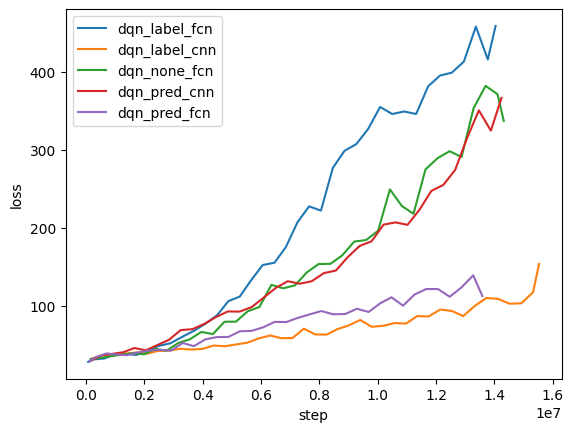

In [63]:
for stat, df in loss_container.items():
    df = df.reset_index()
    df = df.sort_values('step_indx')
    sns.lineplot(data=df, x='step', y='loss', label=stat)

In [41]:
stat_container = {}
stats = glob.glob('rl_stats/*_reward.csv')
for stat_path in stats:
    stat_name = os.path.basename(stat_path).split('_reward')[0]
    stat_container[stat_name] = pd.read_csv(stat_path)
    stat_container[stat_name]['wall_time'] = pd.to_datetime(stat_container[stat_name]['wall_time'])
    stat_container[stat_name] = reward_window(stat_container[stat_name].copy())
    stat_container[stat_name].to_csv(f'rl_stats/{stat_name}_reward_window.csv', index=False)

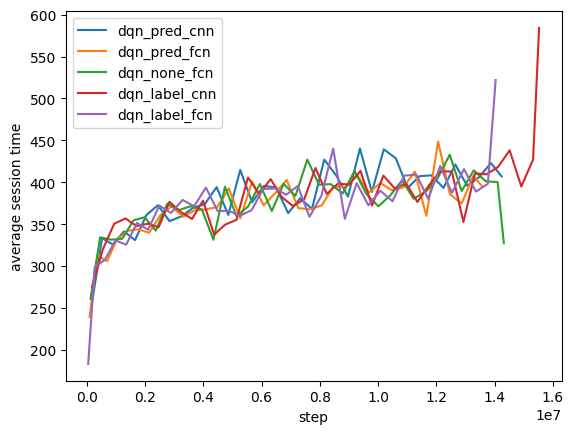

In [42]:
for stat, df in stat_container.items():
    df = df.reset_index()
    df = df.sort_values('step_indx')
    sns.lineplot(data=df, x='step', y='average session time', label=stat)

In [47]:
index_cont = []
for stat, df in stat_container.items():
    df = df.reset_index()
    df = df.sort_values('step_indx')
    index_cont.append(
        {
            'model': stat,
            'reward': df.iloc[-1]['average session time'],
        }
    )

index_df = pd.DataFrame(index_cont)
index_df['model'] = index_df['model'].str.replace('_', ' ')
    

In [58]:
index_loss = []
for stat, df in loss_container.items():
    df = df.reset_index()
    df = df.sort_values('step_indx')
    index_loss.append(
        {
            'model': stat,
            'loss': df.iloc[-1]['loss'],
        }
    )
loss_df = pd.DataFrame(index_loss)
loss_df['model'] = loss_df['model'].str.replace('_', ' ')


In [60]:
print(loss_df.to_latex(index=False))

\begin{tabular}{lr}
\toprule
model & loss \\
\midrule
dqn label fcn & 459.212946 \\
dqn label cnn & 153.654251 \\
dqn none fcn & 337.075012 \\
dqn pred cnn & 366.849845 \\
dqn pred fcn & 112.295042 \\
\bottomrule
\end{tabular}



In [48]:
print(index_df.to_latex(index=False, float_format='%.2f'))


\begin{tabular}{lr}
\toprule
model & reward \\
\midrule
dqn pred cnn & 407.06 \\
dqn pred fcn & 394.81 \\
dqn none fcn & 327.45 \\
dqn label cnn & 584.19 \\
dqn label fcn & 522.05 \\
\bottomrule
\end{tabular}

